In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
import random
import pandas as pd
import numpy as np
from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import math


In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 10
EPOCHS = 1
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 16
IMG_SIZE = 224
IN_CHANNELS = 3
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 512
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = 64
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, emb_dim, patch_size, num_patches, dropout):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=emb_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )
        
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, emb_dim)), requires_grad=True)  # Adjusted cls_token size
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, emb_dim)), requires_grad=True)  # Adjusted position_embeddings size
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # Expand cls_token across batch dimension
        x = self.patcher(x)
        x = x.permute(0, 2, 1)  # Permute dimensions for concatenation
        x = torch.cat([cls_token, x], dim=1)  # Concatenate cls_token with patch embeddings
        
        if x.shape[1] != self.position_embeddings.shape[1]:
            self.position_embeddings = nn.Parameter(self.position_embeddings.data[:, :x.shape[1], :])
        
        x += self.position_embeddings  # Add positional embeddings
        x = self.dropout(x)
        return x
# model = PatchEmbedding(IN_CHANNELS, EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT).to(device)
# x = torch.randn(size = (512, 3, 224, 224)).to(device)
# print(model(x).shape)

In [ ]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class ResidualConnection(nn.Module):
    
    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # To Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, dropout: nn.Dropout):
        d_k = query.shape[-1]
        
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
 
        return self.w_o(x)

class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x
    
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [ ]:
class ViT(nn.Module):
    def __init__(self, input_channels, embed_dim, patch_size, num_patches, num_heads, num_encoders, num_classes, activation, dropout, hidden_dim):
        super().__init__()
        
        self.embeddings_block = PatchEmbedding(input_channels, embed_dim, patch_size, num_patches, dropout)
        
        encoder_blocks = []
        for _ in range(num_encoders):
            encoder_self_attention_block = MultiHeadAttentionBlock(embed_dim, num_heads, dropout)
            feed_forward_block = FeedForwardBlock(embed_dim, hidden_dim, dropout)
            encoder_block = EncoderBlock(embed_dim, encoder_self_attention_block, feed_forward_block, dropout)
            encoder_blocks.append(encoder_block)
        
        self.encoder = Encoder(embed_dim, nn.ModuleList(encoder_blocks))
# ------------------ Using inbuilt encoder ----------------------
#         encoder_layer = nn.TransformerEncoderLayer(
#         d_model=embed_dim, 
#         nhead=num_heads, 
#         dropout=dropout, 
#         activation=activation, 
#         batch_first=True, 
#         norm_first=True
#         )
#         self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder(x)
        x = self.mlp_head(x[:, 0, :])
        return x
    
model = ViT(IN_CHANNELS, EMBED_DIM, PATCH_SIZE, NUM_PATCHES, NUM_HEADS, NUM_ENCODERS, NUM_CLASSES, ACTIVATION, DROPOUT, HIDDEN_DIM).to(device)
# x = torch.randn(10, 3, 224, 224).to(device)
# print(model(x).shape)

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a fixed size
    transforms.ToTensor(),          # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [ ]:
train_dataset = ImageFolder(root='/kaggle/input/state-farm-distracted-driver-detection/imgs/train', transform=transform)

In [ ]:
print(train_dataset[0][1])

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
batch_size = BATCH_SIZE

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
train_accuracy = []
val_accuracy = []
train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    
    for idx, (images, labels) in enumerate(tqdm(train_loader, position=0, leave=True)):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)  # labels should be 1D tensor of class indices
        loss.backward()
        optimizer.step()
        

        train_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().detach().numpy())
        train_preds.extend(predicted.cpu().detach().numpy())

    train_loss = train_running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(tqdm(val_loader, position=0, leave=True)):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().detach().numpy())
            val_preds.extend(predicted.cpu().detach().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

#     print("-"*30)
#     print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
#     print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    
    train_acc = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
    train_accuracy.append(train_acc)
    #print(f"Train Accuracy EPOCH {epoch+1}: {train_acc:.4f}")
    
    val_acc = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
    #print(f"Valid Accuracy EPOCH {epoch+1}: {val_acc:.4f}")
    val_accuracy.append(val_acc)
    
    #print("-"*30)

stop = timeit.default_timer()
#print(f"Training Time: {stop-start:.2f}s")



In [ ]:
model_save_path = f"/kaggle/working/model.pth"
torch.save(model.state_dict(), model_save_path)

In [ ]:
import json

path = '/kaggle/working/train_losses'
with open(path, 'w') as file:
    json.dump(train_losses, file)
    

path = '/kaggle/working/val_losses'
with open(path, 'w') as file:
    json.dump(val_losses, file)
    
path = '/kaggle/working/train_accuracy'
with open(path, 'w') as file:
    json.dump(train_accuracy, file)
    
path = '/kaggle/working/val_accuracy'
with open(path, 'w') as file:
    json.dump(val_accuracy, file)

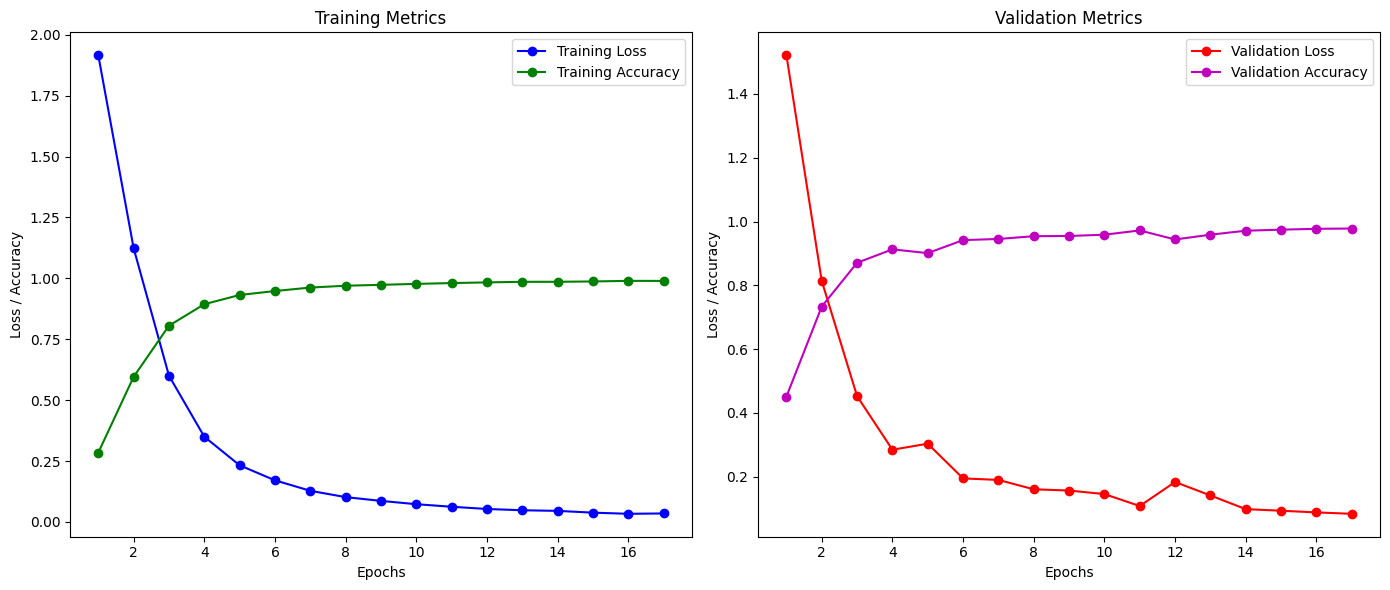

In [44]:
import matplotlib.pyplot as plt

epochs = list(range(1, 18))  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  

# Plotting training loss and accuracy
ax1.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
ax1.plot(epochs, train_accuracy, marker='o', linestyle='-', color='g', label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss / Accuracy')
ax1.set_title('Training Metrics')
ax1.legend()

# Plotting validation loss and accuracy
ax2.plot(epochs, val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
ax2.plot(epochs, val_accuracy, marker='o', linestyle='-', color='m', label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss / Accuracy')
ax2.set_title('Validation Metrics')
ax2.legend()

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()
